In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

/home/joaovictor/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0,}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
#Configurações
# A1 - com switch HW, não podendo aumentar/diminuir número de switches SW (número máximo de SW = 1)
# A2 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 2)
# A3 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 3)
# A4 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 4)
# A5 - com switch HW, podendo aumentar/diminuir número de switches SW (número máximo de SW = 5)

# Parâmetros que variam nesta simulação
seeds = [1,2,3,4,5,6,7,8,9,10]
cargas = ["50hosts", "100hosts", "150hosts"]
experimentos = ["a1","a2","a3","a4","a5"]

# Tempo total de simulação
t_sim = 2000

# Intervalo de confiança
confianca = 99

# Imprimir titulos nos gráficos
titulos = False

# Salvar graficos
salvarGraficos = True

In [4]:
# Função para ler os arquivos de log
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosAntes' : mymode, 'SwAtivosDepois' : np.mean, 'AvgCPULoad' : np.mean}

def read_df_decisao ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            #df_carga.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_map))
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Traffic load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_statistics ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-statistics.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Traffic load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_hw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Traffic load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_sw ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            if(experimento[0] == "a"):
                numSW = int(experimento[1])
            df_sw = []
            for sw in range(1,numSW+1):
                df_sed = []
                for seed in seeds:
                    df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-switch-stats-sw"+str(sw)+".log", sep='\s+', index_col=["TimeSec"])
                    df_sed.append (df)
                df_sw.append(pd.concat (df_sed, keys=seeds))
            df_exp.append(pd.concat(df_sw, keys=range(1,numSW+1)))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Traffic load","Experimento","NumSW","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_ping ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingHW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "HW"
                df_sed.append (df)
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-pingSW.log", sep='\s+', index_col=["seq"])
                df['Switch'] = "SW"
                df_sed.append (df)
            df_exp.append(pd.concat (df_sed, keys=seeds))
        df_carga.append (pd.concat (df_exp, keys=experimentos))
    df_read = pd.concat (df_carga, keys=cargas, names=["Traffic load","Experimento","Seed","TimeSec"], copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read

def read_df_iperfs ():
    df_carga = []
    for carga in cargas:
        df_exp = []
        for experimento in experimentos:
            df_sed = []
            for seed in seeds:
                df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+experimento+"-"+carga+"-"+str(seed)+"-iperfs.log", sep='\s+')
                df_sed.append (df)
            #df_carga.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_map))
            df_exp.append(pd.concat (df_sed))
        df_carga.append (pd.concat (df_exp))
    df_read = pd.concat (df_carga, keys=cargas, copy=False)
    df_read.rename({"50hosts": "Low", "100hosts": "Medium", "150hosts": "High"}, inplace=True)
    return df_read


In [5]:
df_sw = read_df_sw()
df_sw = df_sw.loc[(df_sw["LoaKbps"]!=0)]
df_sw["%drop"] = (df_sw["LoaDrps"]/(df_sw["Packets"]+df_sw["LoaDrps"]) )
df_sw.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5" }, inplace=True)
#df_sw

In [6]:
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400").groupby(["Traffic load", "Experimento", "Seed"]).mean()
df_sw.reset_index(inplace=True)

In [7]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0, "legend.title_fontsize": 13.75}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)
sns.set_palette (sns.color_palette (["#90addb", "#3e6cb1", "#26354b"]))
sns.set_palette (sns.color_palette (["#9e9ac8", "#6a51a3", "#3f007d"]))



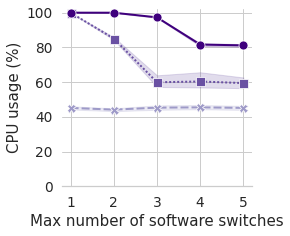

In [8]:

snsplt = sns.relplot( x="Experimento", y="LoaUsag", 
            hue="Traffic load", height=3.5, aspect=1.1,
            kind="line", legend=False, data=df_sw, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if(titulos):
    snsplt.fig.suptitle('Uso dos switches SW (CPU)', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "CPU usage (%)")
snsplt.set(ylim=(0,102))
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/A-UsoCPUSW.pdf")

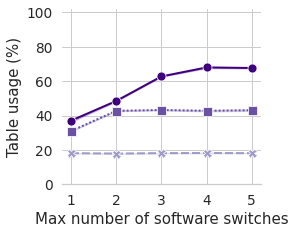

In [9]:
snsplt = sns.relplot( x="Experimento", y="FloUsag",
            hue="Traffic load", height=3.5, aspect=1.1,
            kind="line", legend=False, data=df_sw, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Uso dos switches SW (Tabela)', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Table usage (%)")
snsplt.set(ylim=(0,102))
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/A-UsoTabelaSW.pdf")

In [10]:
df_decisao = read_df_decisao()
df_decisao.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5" }, inplace=True)
#df_decisao

In [11]:
df_decisao = df_decisao.query("TimeSec > 200 and TimeSec < 400").groupby(["Traffic load", "Experimento", "Seed"]).mean()
df_decisao.reset_index(inplace=True)
#df_decisao.replace({"Experimento":{"a":1,"b":2,"c":3,"d":4}}, inplace=True)
df_decisao

,Traffic load,Experimento,Seed,SwAtivosAntes,AvgCPULoad,SwAtivosDepois
0,High,1,1,1.000000,1.000000,1.000000
1,High,1,2,1.000000,1.000000,1.000000
2,High,1,3,1.000000,1.000000,1.000000
3,High,1,4,1.000000,1.000000,1.000000
4,High,1,5,1.000000,1.000000,1.000000
5,High,1,6,1.000000,1.000000,1.000000
6,High,1,7,1.000000,1.000000,1.000000
7,High,1,8,1.000000,1.000000,1.000000
8,High,1,9,1.000000,1.000000,1.000000
9,High,1,10,1.000000,1.000000,1.000000


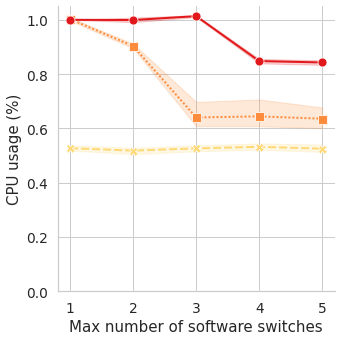

In [12]:
snsplt = sns.relplot(palette="YlOrRd", x="Experimento", y="AvgCPULoad",
            hue="Traffic load",
            kind="line", legend=False, data=df_decisao, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Uso do switch SW (CPU) - Gráfico Igual', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "CPU usage (%)")
snsplt.set(ylim=(0,1.05))

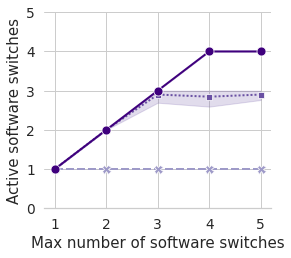

In [13]:
snsplt = sns.relplot(x="Experimento", y="SwAtivosDepois",
            hue="Traffic load", height=3.5, aspect=1.1,
            kind="line", legend=False, data=df_decisao, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if(titulos):
    snsplt.fig.suptitle('Número de switches SW ativos', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Active software switches")
snsplt.set(ylim=(0,5), yticks=(0,1,2,3,4,5))
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/A-NumeroSWAtivos.pdf")

In [14]:
df_stats = read_df_statistics()
df_stats.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5" }, inplace=True)

# df_stats.drop(columns=["AvgLoad"], inplace=True)
# df_stats.rename(columns={"SW": "SWAtivos", "Ativos": "AvgLoad"}, inplace=True)
#df_stats

In [15]:
df_stats_bloq = df_stats[["RegrasBloqueadas", "RegrasAceitas"]].query("TimeSec > 200 and TimeSec < 400").groupby(["Traffic load", "Experimento", "Seed"]).sum()
df_stats_bloq.reset_index(inplace=True)
df_stats_bloq["block"] = (df_stats_bloq["RegrasBloqueadas"]/(df_stats_bloq["RegrasAceitas"]+df_stats_bloq["RegrasBloqueadas"]) )
df_stats_bloq.rename (columns={"Traffic load": "Traffic load"}, inplace=True)
df_stats_bloq

,Traffic load,Experimento,Seed,RegrasBloqueadas,RegrasAceitas,block
0,High,1,1,6260,8760,0.416778
1,High,1,2,6304,8443,0.427477
2,High,1,3,6214,8908,0.410924
3,High,1,4,6296,8660,0.420968
4,High,1,5,6219,8378,0.426046
5,High,1,6,6245,8729,0.417056
6,High,1,7,5935,8987,0.397735
7,High,1,8,6107,8598,0.415301
8,High,1,9,6045,8831,0.406359
9,High,1,10,6481,8333,0.437492


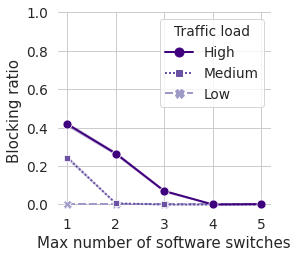

In [16]:
snsplt = sns.relplot(x="Experimento", y="block",
            hue="Traffic load", height=3.5, aspect=1.1, facet_kws={"legend_out":False},
            kind="line", legend="full", data=df_stats_bloq, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Regras bloqueadas', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Blocking ratio")
snsplt.set(ylim=(-0.02,1))
snsplt.despine(left=True, bottom=True)
leg = snsplt._legend
# leg.set_bbox_to_anchor([0.47, 0.55])
# leg._loc = 2
leg.set_frame_on(True)
order = [2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper right", title="Traffic load")

if (salvarGraficos):
    snsplt.savefig("Graficos/A-Bloqueios.pdf")

In [17]:
df_hw = read_df_hw()
df_hw.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5" }, inplace=True)
#df_hw

In [18]:
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400").groupby(["Traffic load", "Experimento", "Seed"]).mean()
df_hw.reset_index(inplace=True)
# df_hw

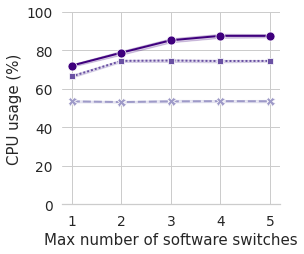

In [19]:

snsplt = sns.relplot( x="Experimento", y="LoaUsag",
            hue="Traffic load", height=3.5, aspect=1.1,
            kind="line", legend=False, data=df_hw, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Uso do switch HW (CPU)', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "CPU usage (%)")
snsplt.set(ylim=(0,100))
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/A-UsoCPUHW.pdf")

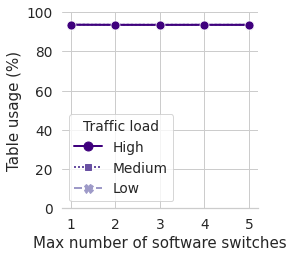

In [20]:
snsplt = sns.relplot(x="Experimento", y="FloUsag",
            hue="Traffic load", height=3.5, aspect=1.1, facet_kws={"legend_out":False},
            kind="line", legend="full", data=df_hw, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Uso do switch HW (Tabela)', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Table usage (%)")
snsplt.set(ylim=(0,100))
leg = snsplt._legend
# leg.set_bbox_to_anchor([0.47, 0.45])
# leg._loc = 2
leg.set_frame_on(True)
snsplt.despine(left=True)
order = [2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="lower left", title="Traffic load")
if (salvarGraficos):
    snsplt.savefig("Graficos/A-UsoTabelaHW.pdf")

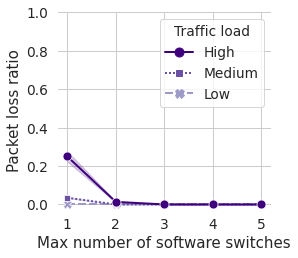

In [21]:
snsplt = sns.relplot( x="Experimento", y="%drop",
            hue="Traffic load", height=3.5, aspect=1.1, facet_kws={"legend_out":False},
            kind="line", legend="full", data=df_sw, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Load drops SW', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Packet loss ratio")
snsplt.set(ylim=(-0.02,1))
leg = snsplt._legend
# leg.set_bbox_to_anchor([0.47, 0.5])
# leg._loc = 2
leg.set_frame_on(True)
snsplt.despine(left=True, bottom=True)
order = [2, 1, 0]
handles, labels = snsplt.ax.get_legend_handles_labels()
snsplt.ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                 loc="upper right", title="Traffic load")
if (salvarGraficos):
    snsplt.savefig("Graficos/A-LoadDropsSW.pdf")

In [22]:
#Lendo os arquivos de ping
df_pingstats = read_df_ping()
df_pingstats.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5"}, inplace=True)
df_pingstats = df_pingstats.query("TimeSec > 200 and TimeSec < 400")
df_pingstats.rename(columns={"time": "Ping"}, inplace=True)
df_pingstats.reset_index(inplace=True)
#df_pingstats

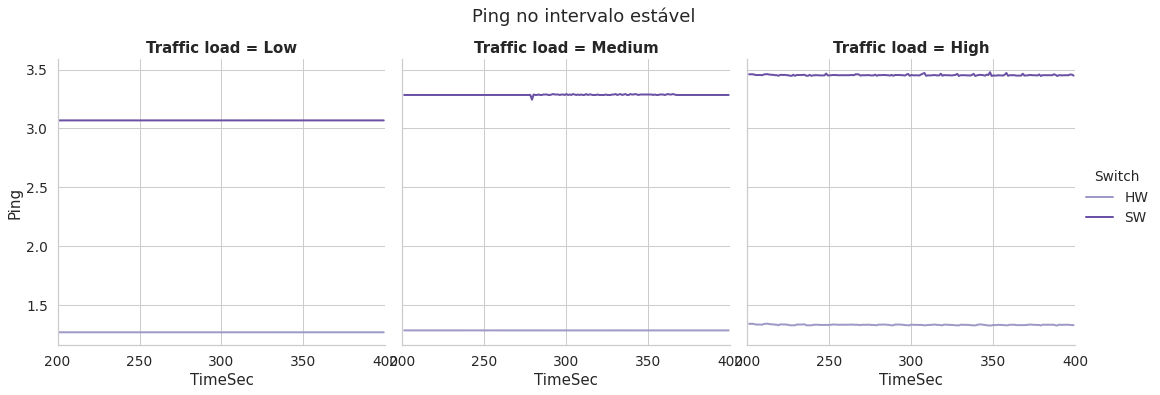

In [23]:
snsplt = sns.relplot(x="TimeSec", y="Ping",
           hue="Switch", col="Traffic load",
           kind="line", legend="full", data=df_pingstats, ci=None)
snsplt.fig.suptitle('Ping no intervalo estável', y=1.05)
snsplt.set(xlim=(200,400))

In [24]:
df_iperfs = read_df_iperfs()
#df_iperfs

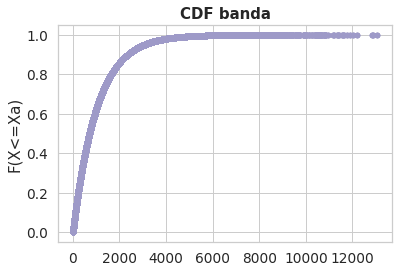

In [25]:
x = np.sort(df_iperfs['Banda(Kbps)'])
y = np.arange(1, len(x)+1) / float(len(x))
grafico = plt.plot(x,y,marker='.', linestyle='none')
grafico = plt.xlabel(u"")
grafico = plt.ylabel("F(X<=Xa)")
grafico = plt.title("CDF banda")
plt.show()

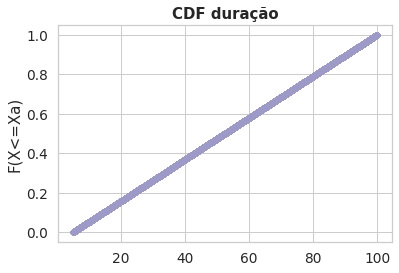

In [26]:
x = np.sort(df_iperfs['Duracao(seg)'])
y = np.arange(1, len(x)+1) / float(len(x))
grafico = plt.plot(x,y,marker='.', linestyle='none')
grafico = plt.xlabel(u"")
grafico = plt.ylabel("F(X<=Xa)")
grafico = plt.title("CDF duração")
plt.show()

In [27]:
df_sw = read_df_sw()
df_sw = df_sw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_sw = df_sw.loc[(df_sw["Packets"]!=0)]
df_sw = df_sw.groupby(["Traffic load", "Experimento", "NumSW", "Seed"]).mean()[["LoaKbps"]]
df_sw = df_sw.groupby(["Traffic load", "Experimento", "Seed"]).sum()
df_sw = df_sw.rename(columns={"LoaKbps" : "LoaKbpsSW"})
#df_sw.reset_index(inplace = True)

df_hw = read_df_hw()
df_hw = df_hw.query("TimeSec > 200 and TimeSec < 400")[["LoaKbps","Packets"]]
df_hw = df_hw.loc[(df_hw["Packets"]!=0)]
df_hw = df_hw.groupby(["Traffic load", "Experimento", "Seed"]).mean()[["LoaKbps"]]
df_hw = df_hw.rename(columns={"LoaKbps" : "LoaKbpsHW"})
#df_hw.reset_index(inplace = True)


df_total = pd.concat([df_sw, df_hw], axis=1)
df_total.rename({"a1" : "1", "a2" : "2", "a3" : "3", "a4" : "4", "a5" : "5" }, inplace=True)
df_total["Soma"] = df_total["LoaKbpsSW"] + df_total["LoaKbpsHW"]
df_total.reset_index(inplace = True)
df_total['Soma'] = df_total['Soma']/1e6

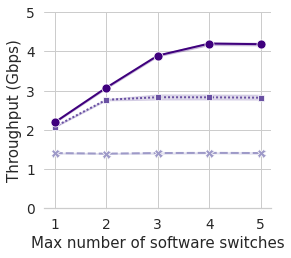

In [28]:

snsplt = sns.relplot(x="Experimento", y="Soma",
            hue="Traffic load", height=3.5, aspect=1.1, 
            kind="line", legend=False, data=df_total, ci=confianca, style="Traffic load", markers=True, hue_order=["Low", "Medium", "High"])
if (titulos):
    snsplt.fig.suptitle('Vazão Agregada Média', y=1.05)
snsplt.set_axis_labels("Max number of software switches", "Throughput (Gbps)")
# snsplt.set_axis_labels("Max number of sw switches $\beta$", "Throughput (Gbps)")
snsplt.set(ylim=(0,5))
snsplt.despine(left=True)
if (salvarGraficos):
    snsplt.savefig("Graficos/A-VazaoAgregadaMedia.pdf")